In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# make the plot beautiful
sns.set_style('whitegrid')

In [2]:
def plot_results(results):
    """
    Plot the train/test RMSE results
    """
    # plot configuration
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)

    # exponential moving average of RMSE to smooth out the output
    _ = results.ewm(halflife=25).mean().plot(ax=ax)
    _ = ax.set_xlabel("Number of Epochs")
    _ = ax.set_ylabel("RMSE")
    _ = ax.set_title("Content-based Model Learning Curve")

    return fig, ax

### Problem Formulation and Data Pipeline

Here we have three entities, user $U$, movie $M$, and rating $R$. Any user can rate any arbitrary number of movies; therefore, the amount of ratings $|{R}|$ we have is $|{U \times M}|$ which is around 25M.

We constructed a movie profile based on the given 1,128 tag genome scores, $d=1128$, and some preprocessing. Namely, we write a movie profile $\vec{M} \in \mathbb{R}^d$ with TF-IDF transformation as below. $$ \vec{M_i} = tfidf(M_i, \{M\}) $$

And the user profile is constructed as follow. $$ \vec{U}(U, \{M_j | U\}) = \frac{\sum_{j}^{|\{M_j | U\}|} {R(U, M_j) \cdot \vec{M_j}}} {\sum_{j}^{|\{M_j | U\}|} {R(U, M_j)}}$$ Despite the ugly notation above, in essence, every user profile is a normalized weighted sum of all the movies that a user had rated in the pasted. The weights are chosen as the ratings of this user gave to all the movies.

Lastly, the model is trying to predict the new rating given a user profile and a movie profile, $$ <\vec{U}, \vec{M}> \Rightarrow R(U, M) $$ where $ <\vec{U}, \vec{M}> $ is a feature vector that is $\in \mathbb{R}^{2d}$.

## Visualizing the training results

In [3]:
# read in pre-train model's training result
results = pd.read_feather('./data/model_sgd_regressor_scores.feather')

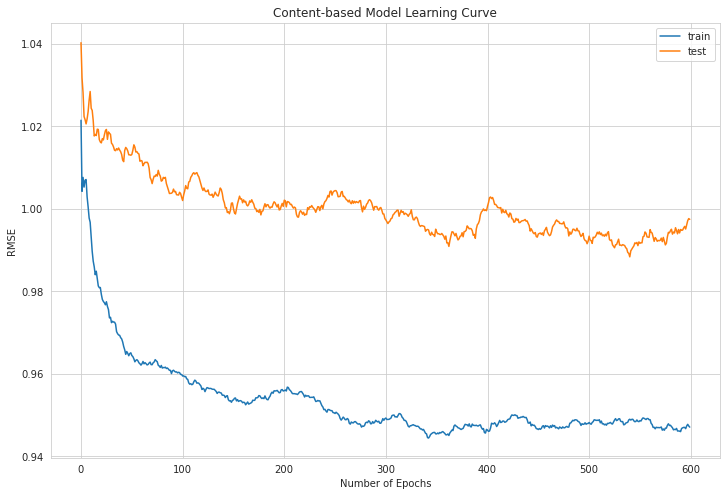

In [4]:
# plot the pre-train results
fig, ax = plot_results(results)

## Getting new Train/Test datasets

In [5]:
def get_train_test(batch_size=5000):
    """Constructing the finalized dataset for model"""
    # samples from rating histories
    sample = hist.sample(batch_size)
    sample = sample.join(user_profile).join(feature_movies)

    # concate user profile and movie genome features to one
    # normalize each row, so that euclidean distance perserve cosine distance
    sample['train'] = (
        sample[~sample.train.isna()]
        .apply(lambda x: np.r_[x.train, x.genome], axis=1)
        .apply(lambda x: x / np.linalg.norm(x))
    )
    sample['test'] = (
        sample.apply(lambda x: np.r_[x.test, x.genome], axis=1)
        .apply(lambda x: x / np.linalg.norm(x))
    )

    # cleanup
    sample.drop(['genome'], axis=1, inplace=True)

    # get train & test subsets
    X_train = np.r_[sample[sample.is_train].train.to_list()]
    y_train = sample[sample.is_train].rating.to_numpy()

    X_test = np.r_[sample[~sample.is_train].test.to_list()]
    y_test = sample[~sample.is_train].rating.to_numpy()

    return X_train, y_train, X_test, y_test

In [7]:
# read in data for constructing training testing set
feature_movies = pd.read_feather('./data/feature_movies.feather').set_index('movieId')
user_profile = pd.read_feather('./data/feature_profile.feather').set_index('userId')
hist = pd.read_feather('./data/feature_hist.feather').set_index(['userId','movieId'])

In [7]:
# read in pre-train model
sgd = joblib.load('./data/model_sgd_regressor.joblib')

In [9]:
from sklearn.metrics import mean_squared_error

# get a batch of train/test dataset
X_train, y_train, X_test, y_test = get_train_test()

# calculate RMSE for this batch
train_score = np.sqrt(mean_squared_error(y_train, sgd.predict(X_train)))
test_score = np.sqrt(mean_squared_error(y_test, sgd.predict(X_test)))

print(f"Train RMSE = {train_score:0.3f}")
print(f"Test RMSE = {test_score:0.3f}")

Train RMSE = 0.933
Test RMSE = 1.024


## Rebuild the model from scratch or Do some additional trainings

In [ ]:
# get the historical training results and pre-train model
sgd = joblib.load('./data/model_sgd_regressor.joblib')
results = pd.read_feather('./data/model_sgd_regressor_scores.feather')

In [8]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

# initilize the SGD Linear Model with L2 loss and penlity
# sgd = SGDRegressor(loss='squared_error', penalty='l2', alpha=0.001)
scores = []

# training loop
n_epochs = 600
batch_size = 5000
for epoch in tqdm(range(n_epochs)):
    # get train test data
    X_train, y_train, X_test, y_test = get_train_test(batch_size)

    # sgd batch fit
    sgd.partial_fit(X_train, y_train)

    # calcualte scores
    train_rmse = np.sqrt(mean_squared_error(y_train, sgd.predict(X_train)))
    test_rmse = np.sqrt(mean_squared_error(y_test, sgd.predict(X_test)))
    scores.append((epoch, train_rmse, test_rmse))

# read the train/test RMSE results into pandas dataframe
results2 = pd.DataFrame(scores, columns=['epoch','train', 'test'])[['train','test']]

  0%|          | 0/600 [00:00<?, ?it/s]

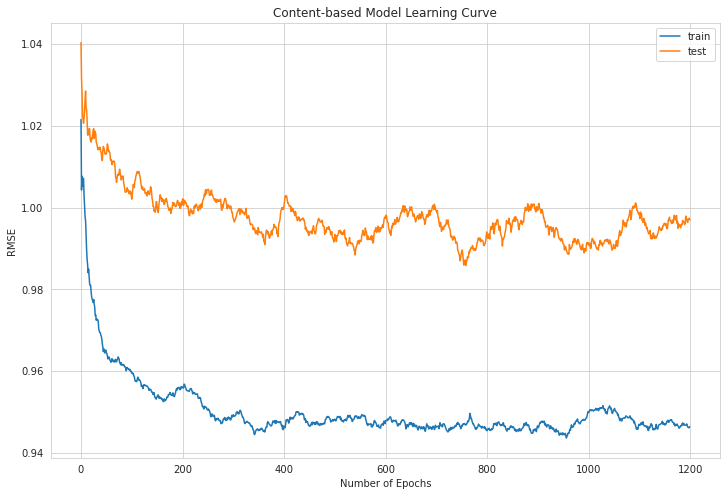

In [17]:
# plot out the new training results
new_results = pd.concat([results, results2]).reset_index(drop=True)
fig, ax = plot_results(new_results)